Loading the necessary libraries

In [ ]:
import tensorflow 
import numpy as np
import time
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import wordnet

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk

nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, GRU, BatchNormalization
from tensorflow.keras.layers import Input, Bidirectional, GlobalAveragePooling1D, concatenate, LeakyReLU, GlobalMaxPooling1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
from keras_preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.8 MB/s eta 0:00:00


In [ ]:
# !pip install Keras-Preprocessing

In [ ]:
import tensorflow as tf

# Device name
device_name = tf.test.gpu_device_name()

# Check if the GPU is detected
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch


if torch.cuda.is_available():    

       
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Mount drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Load the data

In [ ]:
# Train data 
all_train = pd.read_csv('/content/gdrive/MyDrive/all_train.tsv',sep='\t')
# Validation data 
all_validate = pd.read_csv('/content/gdrive/MyDrive/all_validate.tsv',sep='\t')
# Test data 
all_test_public = pd.read_csv('/content/gdrive/MyDrive/all_test_public.tsv',sep='\t')

I select a subset of the dataframe with no missing values in the 'clean_title' column

In [ ]:
# Train data with no missing values
all_train_data = all_train[all_train['clean_title'].notna()]
# Validation data with no missing values
all_validate_data = all_validate[all_validate['clean_title'].notnull()]
# Test data with no missing values
all_test_public_data = all_test_public[all_test_public['clean_title'].notnull()]


I separate the datasets into text and labels.

In [ ]:
## Train data
train_Data_news = list(all_train_data['clean_title'])
train_Data_labels = list(all_train_data['6_way_label'])
## Valid data
valid_Data_news = list(all_validate_data['clean_title'])
valid_Data_labels = list(all_validate_data['6_way_label'])
## Test data
test_Data_news = list(all_test_public_data['clean_title'])
test_Data_labels = list(all_test_public_data['6_way_label'])


**Preprocessing**

Remove multiple spaces, punctuations and numbers.

In [ ]:
import string

def preprocess_text(sen):
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    sen = sen.translate(translator)

    # Remove multiple spaces
    sen = re.sub(r'\s+', ' ', sen)

    # Remove leading and trailing spaces
    sen = sen.strip()

    # Convert to lowercase
    sen = sen.lower()

    return sen


In [ ]:
# Remove puntuations and numbers and multiple spaces

clean_data_train_news = [preprocess_text(new) for new in train_Data_news]
clean_data_valid_news = [preprocess_text(new) for new in valid_Data_news]
clean_data_test_news = [preprocess_text(new) for new in test_Data_news]


**Define a function to remove stop words and perform lemmatization.**

use part-of-speech tagging to determine the part of speech of each word, which is used to determine the correct form of the word during lemmatization. 
A more efficient way to lemmatize the words would be to determine their part of speech using pos_tag, and then call the lemmatizer once with the correct part of speech.
This version of the function uses the lemmatize() function of the WordNetLemmatizer class, which can work on words without specifying the part of speech. This version also removes the use of multiple round of lemmatization which is not needed. This method is simpler and faster than using part-of-speech tagging, but it may not be as accurate because it doesn't take the context of the word into account.

In [ ]:
# Initialize  lemmatizer and  stop_words
import nltk
nltk.download('omw-1.4')
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

def remove_stopwords_lem(text):
    # Tokenize the text
    text = word_tokenize(text)

    # Remove stopwords
    text = [word for word in text if word not in stop_words]

    # Lemmatize the text
    lemmatized_text = []
    for word, treebank_pos in pos_tag(text):
        if treebank_pos.startswith('J'):
            wordnet_pos = wordnet.ADJ
        elif treebank_pos.startswith('V'):
            wordnet_pos = wordnet.VERB
        elif treebank_pos.startswith('N'):
            wordnet_pos = wordnet.NOUN
        elif treebank_pos.startswith('R'):
            wordnet_pos = wordnet.ADV
        else:
            wordnet_pos = wordnet.NOUN
        lemmatized_text.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    # Concatenate the lemmatized words into a single string
    return ' '.join(lemmatized_text)


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


This will display a progress bar as the list comprehension runs, which can be helpful for tracking progress and estimating the time remaining.

In [ ]:
# Remove stop words and perform lemmatization
from tqdm import tqdm
train_stop_word_lemmatized = [remove_stopwords_lem(new) for new in tqdm(clean_data_train_news)]
valid_stop_word_lematized = [remove_stopwords_lem(new) for new in tqdm(clean_data_valid_news)]
test_stop_word_lemmtized = [remove_stopwords_lem(new) for new in tqdm(clean_data_test_news)]


100%|██████████| 84481/84481 [00:44<00:00, 1891.53it/s]


Tokenize the news. In order to do this, loading the tokenizer which is included with BERT. Using the 'uncased' version.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Define a function that will tokenize each sentence and map the tokens to their corresponding IDs in the tokenizer vocabulary.

In [ ]:
# Tokenize the sentence and add the '[CLS]' and '[SEP]' tokens.

def bert_tokenize(text):

    encoded_text = tokenizer.encode(
                        text,                      
                        add_special_tokens = True 

                       )
    return encoded_text

This will split the tokenization process across multiple cores, allowing you to tokenize multiple sentences in parallel.

Performing the tokenization as a separate pre-processing step and save the tokenized data to disk so that you don't need to tokenize the text every time you work with them.

In [ ]:

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

def tokenize_list(lst):
    with ProcessPoolExecutor() as executor:
        return list(executor.map(bert_tokenize, lst))
train_tokenized = tokenize_list(train_stop_word_lemmatized )
valid_tokenized = tokenize_list(valid_stop_word_lematized)
test_tokenized = tokenize_list(test_stop_word_lemmtized)


Tokenized each new and then pad the sequences so that all have the same length. The maximum length allowed by BERT is 512. In order to choose the appropiate length to pad the sequences, taking a look at what % of news have a length smaller than a given number.

In [ ]:
lengths_train = np.array([len(new) for new in train_tokenized])
lengths_valid = np.array([len(new) for new in valid_tokenized])
lengths_test = np.array([len(new) for new in test_tokenized])                        

length = 15

for data_set, lengths in zip(["train", "validation", "test"],[lengths_train, lengths_valid, lengths_test]):
    print(f"The {(np.sum(lengths < length)/lengths.shape[0]) * 100}% of the tokenized news in the {data_set} partition has length smaller than {length}")


The 92.53440194123237% of the tokenized news in the train partition has length smaller than 15
The 92.4529194662629% of the tokenized news in the validation partition has length smaller than 15
The 92.40539292858749% of the tokenized news in the test partition has length smaller than 15


This will pad all the sequences to the same length, truncating any that are longer than the specified max length.

In [ ]:

from keras_preprocessing.sequence import pad_sequences
MAX_LEN = 15

# Train
train_padded = pad_sequences(train_tokenized, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
# Validation
valid_padded = pad_sequences(valid_tokenized, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
# Test
test_padded = pad_sequences(test_tokenized, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")


This function takes in a tokenized sequence as an input and creates an attention mask for that sequence. It creates a mask with the same shape as the tokenized sequence, and sets all the values of the mask to 1 where the corresponding value in the tokenized sequence is not 0. This indicates that the corresponding token in the tokenized sequence is not a padding token. All the values in the mask that correspond to padding tokens in the tokenized sequence will be set to 0.


In [ ]:

# Function to obtain the attention mask of each sequence

def attention_mask(tokenized_sequence):
    mask = (tokenized_sequence != 0).astype(int)
    return mask


This will take the padded sequences, which have already been tokenized and apply the attention mask function on them to create the attention mask.

In [ ]:
# Create attention masks
train_attention_masks = attention_mask(train_padded)
valid_attention_masks = attention_mask(valid_padded)
test_attention_masks = attention_mask(test_padded)


Using the numpy.concatenate() function to concatenate the padded sequences, masks, and labels

In [ ]:
# Concatenate train and validation padded sequences
train_valid_padded = np.concatenate([train_padded, valid_padded], axis = 0)
# Concatenate train and validation attention masks
train_valid_masks = np.concatenate([train_attention_masks, valid_attention_masks], axis = 0)
# Concatenate train and validation labels
train_valid_labels = np.concatenate([train_Data_labels, valid_Data_labels], axis = 0)


The torch.tensor() function allows you to convert numpy array to tensors

In [ ]:
# Convert inputs to torch tensor

# Train
train_inputs_tensor = torch.tensor(train_padded, dtype=torch.long)
train_masks_tensor = torch.tensor(train_attention_masks, dtype=torch.long)
train_labels_tensor = torch.tensor(train_Data_labels, dtype=torch.long)

# Validation
validation_inputs_tensor = torch.tensor(valid_padded, dtype=torch.long)
validation_masks_tensor = torch.tensor(valid_attention_masks, dtype=torch.long)
validation_labels_tensor = torch.tensor(valid_Data_labels, dtype=torch.long)

# Train + Validation
train_validation_inputs_tensor = torch.tensor(train_valid_padded, dtype=torch.long)
train_validation_masks_tensor = torch.tensor(train_valid_masks, dtype=torch.long)
train_validation_labels_tensor = torch.tensor(train_valid_labels, dtype=torch.long)

# Test
test_inputs_tensor = torch.tensor(test_padded, dtype=torch.long)
test_masks_tensor = torch.tensor(test_attention_masks, dtype=torch.long)
test_labels_tensor = torch.tensor(test_Data_labels, dtype=torch.long)


I used the shuffle=True argument when creating the DataLoader object. This way, the data will be shuffled during training automatically, and it makes the code less verbose.

In [ ]:
# Create DataLoader objects
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32

# Train
train_dataloader = DataLoader(TensorDataset(train_inputs_tensor, train_masks_tensor, train_labels_tensor), batch_size=batch_size, shuffle=True)

# Validation
valid_dataloader = DataLoader(TensorDataset(validation_inputs_tensor, validation_masks_tensor, validation_labels_tensor), batch_size=batch_size, shuffle=True)

# Train + Validation
train_valid_dataloader = DataLoader(TensorDataset(train_validation_inputs_tensor, train_validation_masks_tensor, train_validation_labels_tensor), batch_size=batch_size, shuffle=True)

# Test
test_dataloader = DataLoader(TensorDataset(test_inputs_tensor, test_masks_tensor, test_labels_tensor), batch_size=batch_size, shuffle=True)


The torch.cuda.is_available() function is used to check if a CUDA-compatible GPU is available. If it returns True, we use the torch.device("cuda") function to create a CUDA device, otherwise, it will use the CPU. Then we use .to() method on model to move the model to that device. This way, we can ensure that the code runs on the GPU if one is available, but it will still run on the CPU if a GPU is not available.

In [ ]:
# Importing necessary libraries
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Defining the model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=6,
    output_attentions=False, 
    output_hidden_states=False
)

# Check for device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

I've added a hyperparameter, weight_decay, to the optimizer. It is a regularization term that helps prevent overfitting by adding an additional term to the loss function which encourages the model to have smaller weights. The regularization strength is controlled by the weight_decay argument, which is a value between 0 and 1.


In [ ]:
# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=2e-5, 
                  eps=1e-8,
                  weight_decay=0.01
                )



The get_linear_schedule_with_warmup function linearly increases the learning rate from 0 to the desired value over a certain number of steps defined by the user. The num_warmup_steps argument controls the number of steps over which the learning rate is increased. The learning rate scheduler is used to adjust the learning rate over time. A common technique is to linearly increase the learning rate over the course of the first few training steps, also called a warmup period.


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 3

# Total number of training steps (batches * number of epochs).
total_steps = len(train_valid_dataloader) * epochs

# Create the learning rate scheduler with a smaller warmup proportion 
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)


Define a function to obtain the accuracy
the mean of the equality between preds and labels and returns the accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1)
    labels_flat = labels
    return (pred_flat == labels_flat).mean()


Function to obtain the elapsed times.

use the strftime method to format the elapsed_rounded value into a string, which represents the elapsed time in the format of hours, minutes, and seconds. The gmtime function converts seconds to the time in format like (hours, minutes, seconds)

In [ ]:
import time

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return time.strftime("%H:%M:%S", time.gmtime(elapsed_rounded))


Tuning the optimal number of epochs

In [31]:
import random

# Set seed for reproducibility.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Create an empty list to store the validation accuracy for each epoch
valid_accuracies = []

# Perform the training for the number of specified epochs
for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    # Set the model to training mode
    model.train()
    
    # Initialize the variables used to track training time and loss
    t0 = time.time()
    total_loss = 0
    
    # Perform a full pass over the training dataset
    for step, batch in enumerate(train_dataloader):
        
        # Unpack the training batch
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        # Clear gradients
        model.zero_grad()
                # Forward pass
        outputs = model(batch_input_ids, 
                    token_type_ids=None, 
                    attention_mask=batch_input_mask, 
                    labels=batch_labels)
        
        # Get loss value
        loss = outputs[0]

        # Store the loss
        total_loss += loss.item()

        # Calculate gradients (backward pass)
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters 
        optimizer.step()

        # Update learning rate
        scheduler.step()

    # Average loss
    avg_train_loss = total_loss / len(train_dataloader)            
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
     
    # After each training epoch, obtain validation accuracy
    accuracy_valid = 0
    repetitions_valid = 0

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Evaluation mode
    model.eval()

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      repetitions_valid += 1

      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
      batch_input_ids = batch[0]
      batch_input_mask = batch[1]
      batch_labels = batch[2]

      with torch.no_grad():        

          # Forward pass
          outputs = model(batch_input_ids, 
                      token_type_ids=None, 
                      attention_mask=batch_input_mask)

          # Get the logits
          logits = outputs[0]

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = batch_labels.to('cpu').numpy()
          # Compute accuracy
          accuracy_valid += flat_accuracy(logits, label_ids)

          # Compute average validation accuracy
          avg_valid_acc = accuracy_valid/repetitions_valid
          valid_accuracies.append(avg_valid_acc)
          print("  Validation Accuracy: {0:.2f}".format(avg_valid_acc))
          print("  Validation took: {:}".format(format_time(time.time() - t0)))

# Select the best validation accuracy and the corresponding number of epochs
best_acc = 0.0
# Check if the current model is the best one.
if avg_valid_acc > best_acc:
  best_acc = avg_valid_acc
  best_epoch = epoch_i + 1
  best_model = model.state_dict()

print("")
print("Training complete!")
print("Best Validation Accuracy: {:.2f} at epoch {}".format(best_acc, best_epoch))


        


Streaming output truncated to the last 5000 lines.
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:04
  Validation Accuracy: 0.80
  Validation took: 00:00:05
  Validation Accuracy: 0.80
  Validation took: 00:00:05
  Validation Accuracy: 0.80
  Validation took: 00:00:05
  Validation Accuracy: 0.80
  Validation took: 00:00:05
  Validation Accuracy: 0.

The following information shows the accuracy, obtaining for each number of epochs.

Epochs 	    Accuracy

1	 0.77

2	 0.78

3	 0.79

The model obtains the highest accuracy over the validation set when it is trained for 3 epochs therefore this is the number of epochs that I will use.


Best Validation Accuracy: 0.79 at epoch 3

**Testing performance**

In order to test the performance, training the model with the train and validation partitions and then evaluating it with the test set. Train the model for 3 epochs.

In [33]:
from transformers import get_linear_schedule_with_warmup
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Select the number of epochs
epochs = 3

# Total number of training steps (batches * number of epochs).
total_steps = len(train_valid_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)
# Early stopping: Stop training if the validation accuracy does not improve for a certain number of consecutive epochs.
#add early stopping
early_stop = EarlyStopping(patience=5, verbose=True)



In [34]:
import random

# Set seed for reproducibility
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each epoch...
for epoch_i in range(0, epochs):

    # Perform one full pass over the training set.
    print("")
    print(f'======== Epoch {epoch_i+1} / {epochs} ========')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the loss
    total_loss = 0

    # Training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_valid_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and step != 0:
            # Elapsed time
            elapsed = format_time(time.time() - t0)
            # Report progress
            print(f'  Batch {step}  of  {len(train_valid_dataloader)}.    Elapsed: {elapsed}.')

        # Unpack the training batch and copy each tensor to the GPU. 
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        # Clear gradients
        model.zero_grad()        

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # Get the loss value
        loss = outputs[0]

        # Accumulate the training loss
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update learning rate
        scheduler.step()

    # Calculate the average loss
    avg_train_loss = total_loss / len(train_valid_dataloader)            
    
    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epcoh took: {format_time(time.time() - t0)}")
    
# Save the model
torch.save(model.state_dict(), '/content/gdrive/MyDrive/SaveModels/BERT_model.pt')      

print("")
print("Training completed")



======== Epoch 1 / 3 ========
Training...
  Batch 40  of  27729.    Elapsed: 00:00:05.
  Batch 80  of  27729.    Elapsed: 00:00:10.
  Batch 120  of  27729.    Elapsed: 00:00:15.
  Batch 160  of  27729.    Elapsed: 00:00:20.
  Batch 200  of  27729.    Elapsed: 00:00:25.
  Batch 240  of  27729.    Elapsed: 00:00:30.
  Batch 280  of  27729.    Elapsed: 00:00:35.
  Batch 320  of  27729.    Elapsed: 00:00:40.
  Batch 360  of  27729.    Elapsed: 00:00:45.
  Batch 400  of  27729.    Elapsed: 00:00:50.
  Batch 440  of  27729.    Elapsed: 00:00:55.
  Batch 480  of  27729.    Elapsed: 00:01:00.
  Batch 520  of  27729.    Elapsed: 00:01:05.
  Batch 560  of  27729.    Elapsed: 00:01:10.
  Batch 600  of  27729.    Elapsed: 00:01:15.
  Batch 640  of  27729.    Elapsed: 00:01:20.
  Batch 680  of  27729.    Elapsed: 00:01:25.
  Batch 720  of  27729.    Elapsed: 00:01:30.
  Batch 760  of  27729.    Elapsed: 00:01:35.
  Batch 800  of  27729.    Elapsed: 00:01:40.
  Batch 840  of  27729.    Elapsed: 00:

Evaluate the model

In [44]:
############ Validation #############

# Obtain performance over the validation set

# Load model
model.load_state_dict(torch.load('/content/drive/MyDrive/SaveModels/BERT_model.pt'))

# Initialize lists to store predictions and labels
predictions = []
labels_test = []

print("Running Validation...")

# Evaluation mode
model.eval()

# Evaluate data for one epoch
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Don't compute and store gradients
    with torch.no_grad():        
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        # Get the "logits"
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Obtain predictions
        pred_flat = np.argmax(logits, axis=1).flatten()
        # Append predictions and labels to the lists
        predictions.extend(pred_flat.tolist())
        labels_test.extend(label_ids.tolist())

    
    # Print classification report
    print(classification_report(np.array(labels_test).reshape(len(labels_test),1), predictions))

   

Running Validation...
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        22
           1       0.00      0.00      0.00         1
           2       0.75      0.75      0.75         4
           3       0.50      0.50      0.50         2
           4       0.50      0.33      0.40         3

    accuracy                           0.72        32
   macro avg       0.51      0.48      0.49        32
weighted avg       0.73      0.72      0.72        32

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        41
           1       0.33      0.50      0.40         2
           2       0.70      0.58      0.64        12
           3       0.50      0.25      0.33         4
           4       0.40      0.40      0.40         5

    accuracy                           0.72        64
   macro avg       0.55      0.52      0.52        64
weighted avg       0.71      0.72      0.71        64



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

Streaming output truncated to the last 5000 lines.
           3       0.63      0.39      0.48      2109
           4       0.76      0.79      0.78     14957
           5       0.76      0.68      0.72      2437

    accuracy                           0.78     72224
   macro avg       0.73      0.66      0.69     72224
weighted avg       0.78      0.78      0.78     72224

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     36191
           1       0.67      0.54      0.60      3827
           2       0.69      0.67      0.68     12728
           3       0.63      0.39      0.48      2109
           4       0.76      0.79      0.78     14963
           5       0.76      0.68      0.72      2438

    accuracy                           0.78     72256
   macro avg       0.73      0.66      0.69     72256
weighted avg       0.78      0.78      0.78     72256

              precision    recall  f1-score   support

           0       0.84  

In [45]:
# Calculate validation accuracy
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 78.57%


In [46]:
# Classification report without 'true' label
print(classification_report(np.array(labels_test).reshape(len(labels_test), 1), predictions, labels = [0,1,2,3,4,5], zero_division=0))


              precision    recall  f1-score   support

           1       0.67      0.55      0.60      4446
           2       0.69      0.67      0.68     14928
           3       0.62      0.39      0.48      2471
           4       0.76      0.79      0.78     17472
           5       0.76      0.68      0.72      2838

   micro avg       0.72      0.69      0.71     42155
   macro avg       0.70      0.62      0.65     42155
weighted avg       0.72      0.69      0.70     42155



In [47]:
# Plot confusion matrix
# Confusion matrix
cm = confusion_matrix(np.array(labels_test), predictions)
print(cm)

[[37171   530  2449   261  1583   332]
 [ 1048  2428   298    66   542    64]
 [ 2766   183 10053    80  1762    84]
 [  870   105   186   960   284    66]
 [ 1767   304  1366   126 13832    77]
 [  526    54   163    50   115  1930]]


This will show a heatmap of the confusion matrix, where the x-axis represents the predicted labels and the y-axis represents the true labels. The cells in the heatmap will be colored based on the number of instances in that cell, with darker colors representing higher numbers. The values in each cell will also be displayed.

It will be showing you how many instances of each true label were predicted as each other label. This way I can see if the model struggles with certain types of samples and focus on improving those.

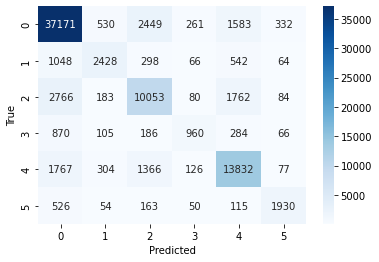

In [48]:
# Visualize confusion matrix
import seaborn as sns
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/SaveModels/BERT_model.pt')

print("")
print("Evaluation completed")


Evaluation completed
